In [ ]:
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.models as models

2025-05-07 08:56:15.444492: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 08:56:15.482601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 08:56:15.482645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 08:56:15.484029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 08:56:15.491184: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
class StructNet(nn.Module):
    def __init__(self):
        super(StructNet, self).__init__()
        
        self.backbone = models.resnet50(weights=None)
        self.shift = nn.Sequential(
            nn.Linear(1000,512), 
            nn.ReLU(),
            nn.Linear(512,3),
        )
        
    def forward(self,x):
        x = self.backbone(x)
        return self.shift(x)

image_path = 'img/1136 HAADF-1.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StructNet()
model.to(device)
model.load_state_dict(torch.load('../model/res2_bs.pth'))
model.eval()
output_all = []
image_raw = Image.open(image_path).convert('RGB')
img_w,img_h = image_raw.size
c_size = 450
wstep = 15  # step size in the horizontal direction
hstep = 15  # step size in the vertical direction
crop_numx = (img_w - c_size) // wstep + 1  # Calculate the number of steps in the horizontal direction.
crop_numy = (img_h - c_size) // hstep + 1  # Calculate the number of steps in the vertical direction.
graph_data_x = np.random.rand(crop_numx, crop_numy)
graph_data_y = np.random.rand(crop_numx, crop_numy)

for i in range(crop_numx):
    for j in range(crop_numy):
        img = TF.crop(image_raw, wstep * i, hstep*j, c_size, c_size)
        img = img.resize([1024,1024])
        img = TF.hflip(img)
        outputs = []
        for d in range(1):
            crop_size = 512+ d * 1
            image_c = TF.crop(img, 0, 0, crop_size, crop_size)
            image_c = image_c.resize([512,512]).filter(ImageFilter.GaussianBlur(radius = 2))
            data = TF.to_tensor(image_c).unsqueeze(0).to(device)
            outputs.append(model(data))
        predict = torch.mean(torch.cat(outputs,dim = 0),dim = 0)
        graph_data_x[i][j] = predict[0].item()
        graph_data_y[i][j] = predict[1].item()

/tmp/ipykernel_16907/2730951316.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model/res2_bs.pth'))


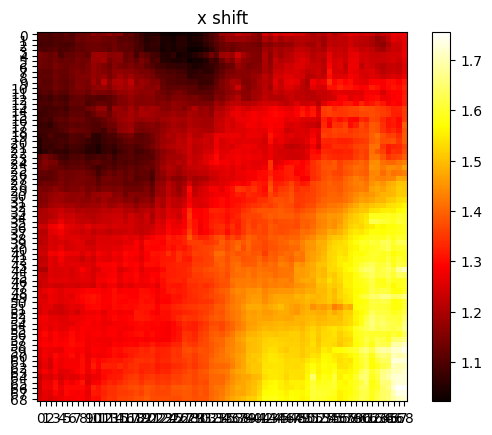

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(graph_data_x, cmap='hot')  

ax.set_xticks(np.arange(len(graph_data_x[0])))
ax.set_yticks(np.arange(len(graph_data_x)))

fig.colorbar(im)  
plt.title('x shift')
plt.show()

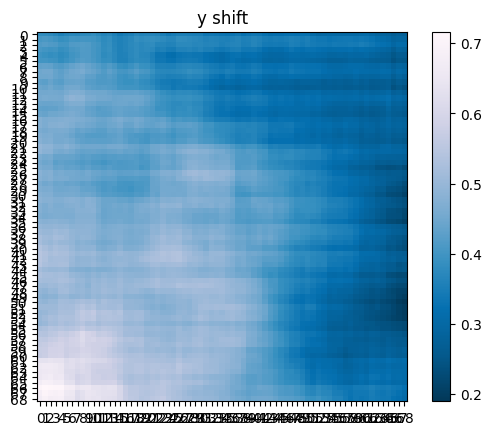

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(graph_data_y, cmap=plt.cm.PuBu_r)  

ax.set_xticks(np.arange(len(graph_data_y[0])))
ax.set_yticks(np.arange(len(graph_data_y)))

fig.colorbar(im)  
plt.title('y shift')
plt.show()